## **ĐỒ ÁN NHẬN DIỆN VÀ PHÂN LOẠI NGƯỜI MANG KHẨU TRANG**

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [71]:
# Bước 1: Load và chuẩn bị data
class MaskDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, folder in enumerate(['mask', 'no_mask']):
            folder_path = os.path.join(data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [72]:
# Đường dẫn đến thư mục chứa dữ liệu
data_dir = 'Dataset/train'

In [73]:
# Định nghĩa các phép biến đổi cho dữ liệu ảnh
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [74]:
# Tạo dataset
dataset = MaskDataset(data_dir, transform=transform)


In [75]:
# Bước 2: Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra bằng cách chia ngẫu nhiên 70,30.
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [76]:
# Tạo DataLoader
batch_size = 49
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [77]:
# Kiểm tra các số lượng của tập dữ liệu
print("Số lượng hình ảnh trong tập huấn luyện:", len(train_dataset))
print("Số lượng hình ảnh trong tập kiểm tra:", len(test_dataset))

Số lượng hình ảnh trong tập huấn luyện: 488
Số lượng hình ảnh trong tập kiểm tra: 210


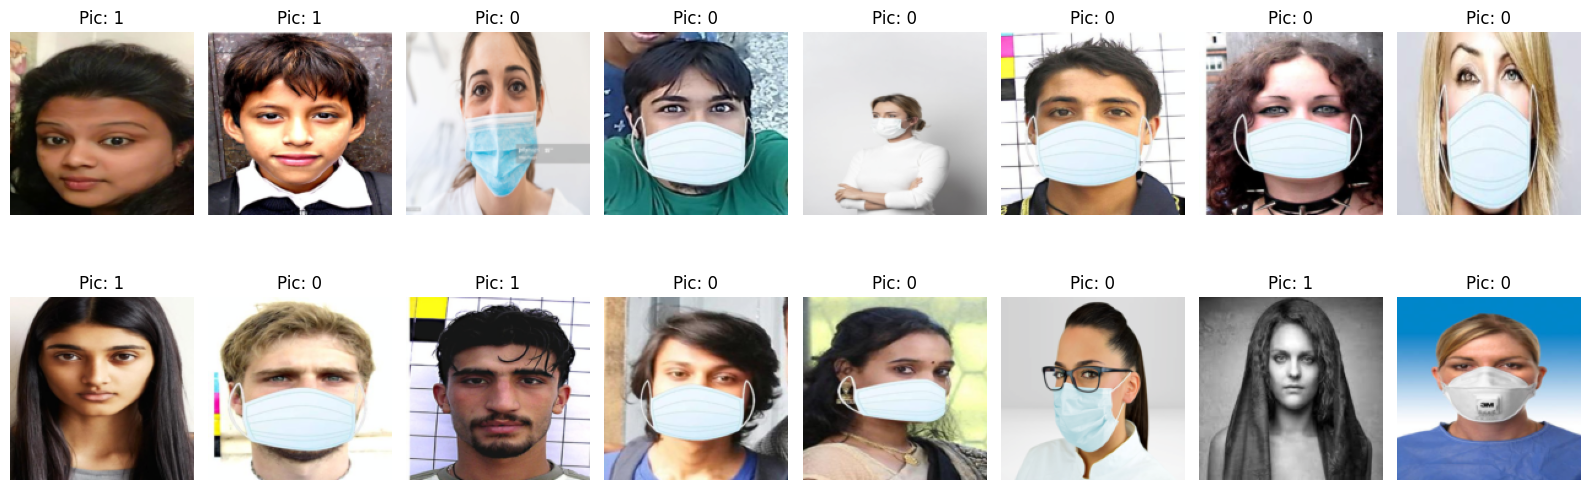

In [78]:
# Lấy một số mẫu ngẫu nhiên từ DataLoader
sample_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
data_iter = iter(sample_loader)
images, labels = next(data_iter)

# Chuẩn bị hiển thị các hình ảnh
fig, axes = plt.subplots(2, 8, figsize=(16, 6))

# Hiển thị từng hình ảnh với nhãn tương ứng
for idx, image in enumerate(images):
    row = idx // 8
    col = idx % 8
    
    # Chuyển đổi tensor về numpy array và điều chuẩn lại để hiển thị đúng
    image = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Pic: {labels[idx].item()}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [79]:
# Xác định mô hình CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [80]:
def check_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'GPU available: {torch.cuda.get_device_name(device)}')
    else:
        device = torch.device('cpu')
        print('No GPU available. Using CPU.')
    
    print(f'Using device: {device}')

# Call the function to check the device
check_device()

No GPU available. Using CPU.
Using device: cpu


In [81]:
# Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [82]:
# Huấn luyện mô hình
n_epochs = 100
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.unsqueeze(1).float()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.unsqueeze(1).float()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            predicted = (outputs >= 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    accuracy = correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/30, Train Loss: 0.6243, Test Loss: 0.5579, Test Accuracy: 0.6939
Epoch 2/30, Train Loss: 0.4086, Test Loss: 0.2422, Test Accuracy: 0.8929
Epoch 3/30, Train Loss: 0.1745, Test Loss: 0.1571, Test Accuracy: 0.9541
Epoch 4/30, Train Loss: 0.1261, Test Loss: 0.2699, Test Accuracy: 0.8980
Epoch 5/30, Train Loss: 0.0970, Test Loss: 0.2087, Test Accuracy: 0.9337
Epoch 6/30, Train Loss: 0.1193, Test Loss: 0.1426, Test Accuracy: 0.9439
Epoch 7/30, Train Loss: 0.0876, Test Loss: 0.1360, Test Accuracy: 0.9592
Epoch 8/30, Train Loss: 0.0673, Test Loss: 0.1355, Test Accuracy: 0.9592
Epoch 9/30, Train Loss: 0.0518, Test Loss: 0.1285, Test Accuracy: 0.9541
Epoch 10/30, Train Loss: 0.0572, Test Loss: 0.1131, Test Accuracy: 0.9643
Epoch 11/30, Train Loss: 0.0705, Test Loss: 0.1323, Test Accuracy: 0.9541
Epoch 12/30, Train Loss: 0.0533, Test Loss: 0.1327, Test Accuracy: 0.9541
Epoch 13/30, Train Loss: 0.0333, Test Loss: 0.1519, Test Accuracy: 0.9643
Epoch 14/30, Train Loss: 0.0177, Test Loss: 0.1

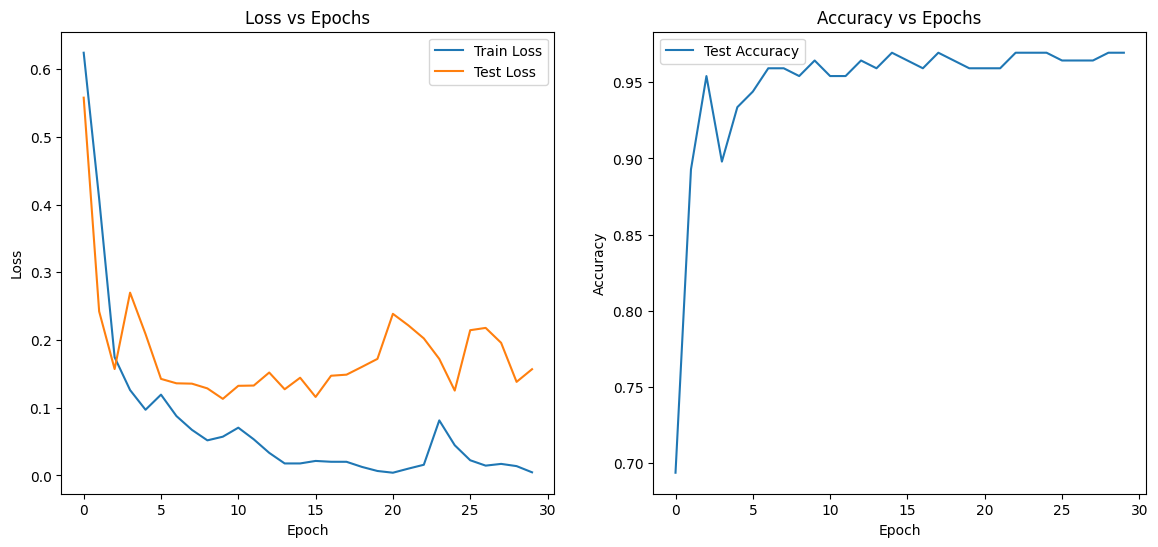

In [83]:
# Vẽ biểu đồ loss và accuracyx
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_title('Loss vs Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [84]:
# Kiểm tra dự đoán của mô hình trên hình ảnh mới
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = output.item()
        return prediction >= 0.5, prediction

In [85]:
# Đường dẫn đến ảnh mới
test_image_paths = ['Test/image2.jpg', 'Test/image1.jpg']

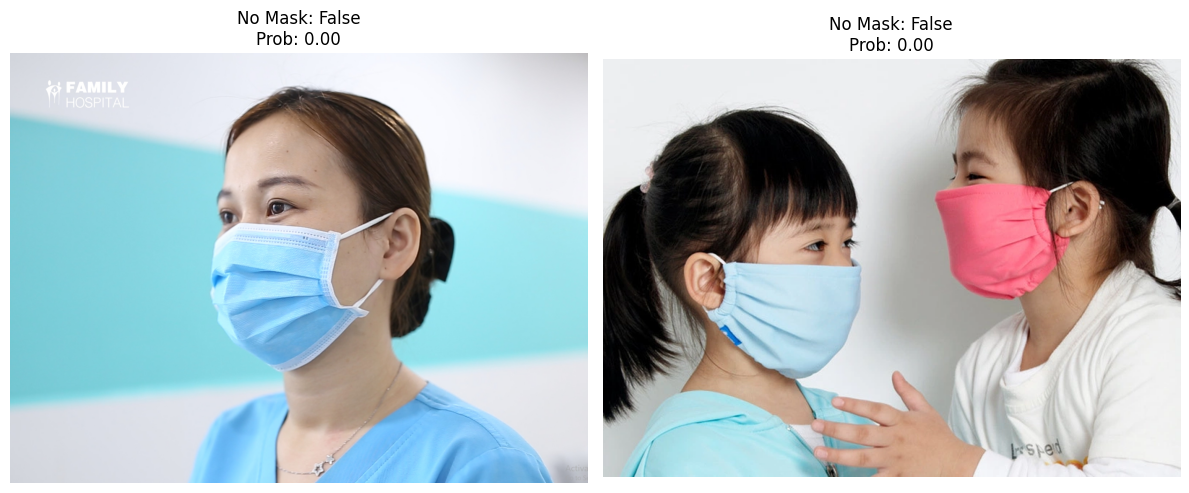

In [90]:
# Tải mô hình đã lưu
model = CNN().to(device)
model.load_state_dict(torch.load('mask_detection_model.pth'))

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(12, 6))
for idx, image_path in enumerate(test_image_paths):
    has_mask, prob = predict_image(image_path, model, transform)
    image = Image.open(image_path).convert('RGB')
    
    axes[idx].imshow(image)
    axes[idx].set_title(f'No Mask: {has_mask}\nProb: {prob:.2f}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()